# Searching for the Higgs Boson #

The Standard Model is a theory in particle physics that describes some of the most basic forces of nature. One fundamental particle, the Higgs boson, is what accounts for the *mass* of matter. First theorized in the 1964, the Higgs boson eluded observation for almost fifty years. In 2012 it was finally observed experimentally at the Large Hadron Collider. These experiments produced millions of gigabytes of data.

Large and complicated datasets like these are where deep learning excels. In this notebook, we'll build a Wide and Deep neural network to determine whether an observed particle collision produced a Higgs boson or not.

# The Collision Data #

The collision of protons at high energy can produce new particles like the Higgs boson. These particles can't be directly observed, however, since they decay almost instantly. So to detect the presence of a new particle, we instead observe the behavior of the particles they decay into, their "decay products".

The *Higgs* dataset contains 21 "low-level" features of the decay products and also 7 more "high-level" features derived from these.

# Wide and Deep Neural Networks #

A *Wide and Deep* network trains a linear layer side-by-side with a deep stack of dense layers. Wide and Deep networks are often effective on tabular datasets.[^1]

Both the dataset and the model are much larger than what we used in the course. To speed up training, we'll use Kaggle's [Tensor Processing Units](https://www.kaggle.com/docs/tpu) (TPUs), an accelerator ideal for large workloads.

We've collected some hyperparameters here to make experimentation easier. Fork this notebook by [**clicking here**](https://www.kaggle.com/kernels/fork/12171965) to try it yourself!

In [1]:
# Model Configuration
UNITS = 2 ** 11 # 2048
ACTIVATION = 'relu'
DROPOUT = 0.1

# Training Configuration
BATCH_SIZE_PER_REPLICA = 2 ** 11 # powers of 128 are best

The next few sections set up the TPU computation, data pipeline, and neural network model. If you'd just like to see the results, feel free to skip to the end!

# Setup #

In addition to our imports, this section contains some code that will connect our notebook to the TPU and create a **distribution strategy**. Each TPU has eight computational cores acting independently. With a distribution strategy, we define how we want to divide up the work between them.

In [2]:
# TensorFlow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# Detect and init the TPU
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
# Plotting
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


# Data
from kaggle_datasets import KaggleDatasets
from tensorflow.io import FixedLenFeature
AUTO = tf.data.experimental.AUTOTUNE


# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

Tensorflow version 2.4.1
Number of accelerators:  8


Notice that TensorFlow now detects eight accelerators. Using a TPU is a bit like using eight GPUs at once.

# Load Data #

The dataset has been encoded in a binary file format called *TFRecords*. These two functions will parse the TFRecords and build a TensorFlow `tf.data.Dataset` object that we can use for training.

In [3]:
def make_decoder(feature_description):
    def decoder(example):
        example = tf.io.parse_single_example(example, feature_description)
        features = tf.io.parse_tensor(example['features'], tf.float32)
        features = tf.reshape(features, [28])
        label = example['label']
        return features, label
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    AUTO = tf.data.experimental.AUTOTUNE
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = (
        tf.data
        .TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(ignore_order)
        .map(decoder, AUTO)
    )
    return dataset

In [4]:
dataset_size = int(11e6)
validation_size = int(5e5)
training_size = dataset_size - validation_size

# For model.fit
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = training_size // batch_size
validation_steps = validation_size // batch_size

# For model.compile
steps_per_execution = 256

In [5]:
feature_description = {
    'features': FixedLenFeature([], tf.string),
    'label': FixedLenFeature([], tf.float32),
}
decoder = make_decoder(feature_description)

data_dir = KaggleDatasets().get_gcs_path('higgs-boson')
train_files = tf.io.gfile.glob(data_dir + '/training' + '/*.tfrecord')
valid_files = tf.io.gfile.glob(data_dir + '/validation' + '/*.tfrecord')

ds_train = load_dataset(train_files, decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .repeat()
    .shuffle(2 ** 19)
    .batch(batch_size)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_files, decoder, ordered=False)
ds_valid = (
    ds_valid
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

# Model #

Now that the data is ready, let's define the network. We're defining the deep branch of the network using Keras's *Functional API*, which is a bit more flexible that the `Sequential` method we used in the course.


In [6]:
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    return make

with strategy.scope():
    # Wide Network
    wide = keras.experimental.LinearModel()

    # Deep Network
    inputs = keras.Input(shape=[28])
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
    outputs = layers.Dense(1)(x)
    deep = keras.Model(inputs=inputs, outputs=outputs)
    
    # Wide and Deep Network
    wide_and_deep = keras.experimental.WideDeepModel(
        linear_model=wide,
        dnn_model=deep,
        activation='sigmoid',
    )

wide_and_deep.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['AUC', 'binary_accuracy'],
    experimental_steps_per_execution=steps_per_execution,
)

# Training #

During training, we'll use the `EarlyStopping` callback as usual. Notice that we've also defined a **learning rate schedule**. It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum). This schedule will multiply the learning rate by `0.2` if the validation loss didn't decrease after an epoch.

In [7]:
early_stopping = callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001,
)

In [8]:
history = wide_and_deep.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_schedule],
)

Epoch 1/50
640/640 [==============================] - 167s 261ms/step - loss: 0.6087 - auc: 0.7522 - binary_accuracy: 0.6867 - val_loss: 0.7474 - val_auc: 0.5861 - val_binary_accuracy: 0.4704
Epoch 2/50
640/640 [==============================] - 28s 43ms/step - loss: 0.4973 - auc: 0.8349 - binary_accuracy: 0.7525 - val_loss: 0.4787 - val_auc: 0.8490 - val_binary_accuracy: 0.7652
Epoch 3/50
640/640 [==============================] - 28s 43ms/step - loss: 0.4784 - auc: 0.8487 - binary_accuracy: 0.7645 - val_loss: 0.4690 - val_auc: 0.8564 - val_binary_accuracy: 0.7718
Epoch 4/50
640/640 [==============================] - 27s 43ms/step - loss: 0.4698 - auc: 0.8548 - binary_accuracy: 0.7704 - val_loss: 0.4645 - val_auc: 0.8588 - val_binary_accuracy: 0.7744
Epoch 5/50
640/640 [==============================] - 27s 42ms/step - loss: 0.4638 - auc: 0.8589 - binary_accuracy: 0.7743 - val_loss: 0.4600 - val_auc: 0.8617 - val_binary_accuracy: 0.7770
Epoch 6/50
640/640 [============================

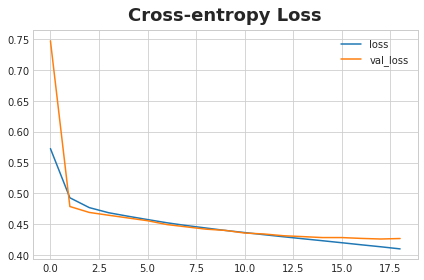

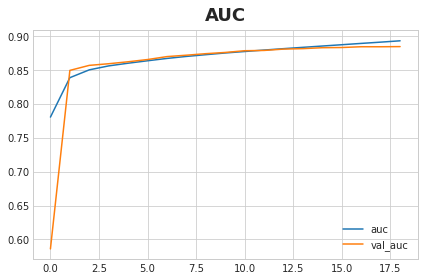

In [9]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(title='Cross-entropy Loss')
history_frame.loc[:, ['auc', 'val_auc']].plot(title='AUC');

# References #

- Baldi, P. et al. *Searching for Exotic Particles in High-Energy Physics with Deep Learning*. (2014) ([arXiv](https://arxiv.org/abs/1402.4735))
- Cheng, H. et al. *Wide & Deep Learning for Recommender Systems*. (2016) ([arXiv](https://arxiv.org/abs/1606.07792))
- *What Exactly is the Higgs Boson?* Scientific American. (1999) [(article)](https://www.scientificamerican.com/article/what-exactly-is-the-higgs/)]

[^1]: In the original implementation, categorical features were one-hot encoded and crossed to produce the interaction features. This "wide" dataset was used with the linear component. For the deep component, the categories were encoded into a much narrower embedding layer.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/191966) to chat with other Learners.*